## Capstone Project: Toxic Comment Classification

---

In this notebook, 

---
### Dataset

The Movie Review Dataset is a collection of movie reviews retrieved from the imdb.com website in the early 2000s by Bo Pang and Lillian Lee. The reviews were collected and made available as part of their research on natural language processing. The dataset can be downloaded from here:

* Movie Review Polarity Dataset (review polarity.tar.gz, 3MB).
  https://goo.gl/L6ZsLv

The dataset is comprised of 1,000 positive and 1,000 negative movie reviews drawn from an archive of the rec.arts.movies.reviews newsgroup hosted at IMDB. The authors refer to this dataset as the “polarity dataset“. The data has been cleaned up somewhat, for example:

* The dataset is comprised of only English reviews.
* All text has been converted to lowercase.
* There is white space around punctuation like periods, commas, and brackets.
* Text has been split into one sentence per line.


From this dataset, I will develop a sentiment analysis deep learning model to predict whether a given movie review is positive or negative.

### Outline

The notebook is divided into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Clean and tokenize the text and save the results to a new file
* [Step 2](#step2): Split the clean data into train and test datasets
* [Step 3](#step3): Develop an Embedding + CNN model on the training dataset (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Movie Review (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Movie Review (using Transfer Learning)
* [Step 6](#step6): Write 
* [Step 7](#step7): Test 

---
<a id='step0'></a>
## Step 0: Import Text Data

### Import Movie Review Dataset

In the code cell below, I import a dataset of IMDB movie reviews. I will look at loading individual text files, then processing the directories of files. A few variables has been populated through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [166]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image
from nltk.corpus import stopwords

#settings
color = sns.color_palette()
sns.set_style("whitegrid")
stopwords_eng = set(stopwords.words("english"))

In [159]:
# load text data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('Trainning set contains {} records and testing set contains {} records.'.format(len(train),len(test)))

Trainning set contains 159571 records and testing set contains 153164 records.


### Inspect Dataset

Inspect a few lines. There are 8 columns. The first column is 'id', the second column is the 'comment text' and the following six columns are labels of the toxicity (1 for toxic, 0 for non-toxic).

In [13]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [161]:
# class imbalance
labels = train.iloc[:,2:8]
row_sum = labels.sum(axis = 1)
# mark comments without any labels as "clean"
train['clean'] = (row_sum == 0)
print('Total comments is {}.'.format(len(train)))
print('The clean comments is {}, which is {} of total comments.'.format(train['clean'].sum(),train['clean'].sum()/len(train)))

Total comments is 159571.
The clean comments is 143346, which is 0.8983211235124177 of total comments.


In [22]:
# check for missing values in the trainning set
missing_train = train.isnull().sum()
missing_test = test.isnull().sum()
missing_train, missing_test

(id               0
 comment_text     0
 toxic            0
 severe_toxic     0
 obscene          0
 threat           0
 insult           0
 identity_hate    0
 clean            0
 dtype: int64, id              0
 comment_text    0
 dtype: int64)

In [36]:
# new function: barplot with text labels for each column
def bar_plot_label(x, y, x_axis, y_axis, filename):
    plt.figure(figsize=(8,4.5))
    ax = sns.barplot(x, y)
    plt.xlabel(x_axis, fontsize = 12)
    plt.ylabel(y_axis, fontsize = 12)
    # add the text labels
    for rect, label in zip(ax.patches, y):
        ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), label,ha = 'center', va='bottom')
    # save the figure as .eps file
    fig = ax.get_figure()
    fig.savefig(filename)
    plt.show()

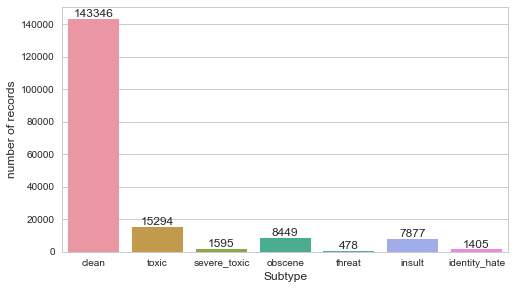

In [66]:
# plot different types of labels
column_sum = pd.Series(labels.sum(axis = 0))
clean = pd.Series(train['clean'].sum(), index = ['clean'])
# add clean document amount as a new type
column_sum = pd.concat([clean, column_sum])
# barplot for different labels
plot_subtype = bar_plot_label(column_sum.index, column_sum.values, 'Subtype', 'number of records','figure/subtype.eps')

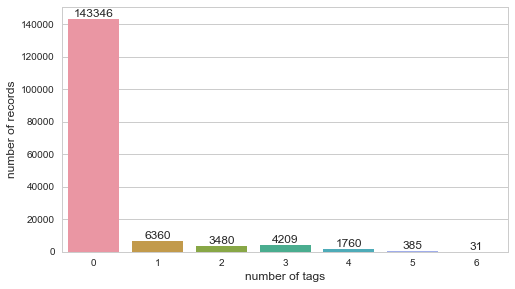

In [47]:
# multi-tagging
multi_tags = [ sum(row_sum == i) for i in range(7)]
multi_tags = pd.Series(multi_tags, index = [0,1,2,3,4,5,6])
bar_plot_label(multi_tags.index, multi_tags.values,'number of tags', 'number of records', 'figure/multi_tags.eps')

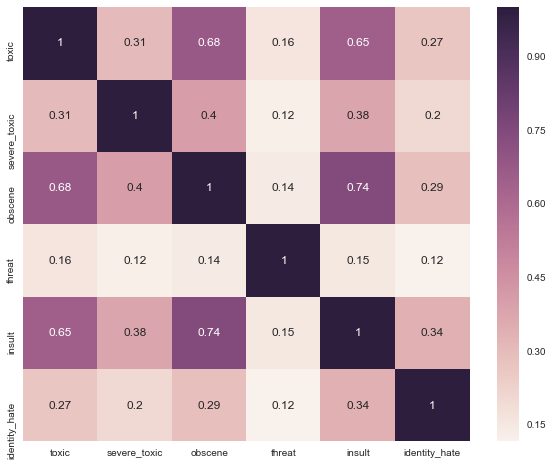

In [70]:
# correlation between subtypes
corr = train.iloc[:,2:8].corr()
plt.figure(figsize = (10,8))
corr_plot = sns.heatmap(corr, annot = True)
plt.show()
# save the figure
fig_corr = corr_plot.get_figure()
fig_corr.savefig('figure/correlation.eps')

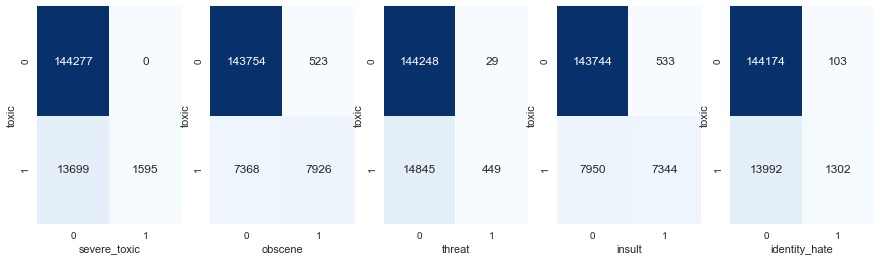

In [114]:
# crosstab
subtypes = ['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
i = 1
plt.figure(figsize = (15,4))
for subtype in subtypes:
    plt.subplot(1,5,i)
    cross = sns.heatmap(pd.crosstab(train['toxic'],train[subtype]),annot = True, fmt = '', cbar = False, cmap = "Blues")
    i += 1
plt.show()  
fig_cross = cross.get_figure()
fig_cross.savefig('figure/crosstab.eps')

In [136]:
all_types = ['clean', 'toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for t in all_types:
    record_number = random.randint(1, train[t].sum())
    print('The {}th record of "{}" comments is:'.format(record_number,t))
    print(train[train[t] == 1].iloc[record_number,1])
    print('')

The 2773th record of "clean" comments is:
Do not remove factual information without good reason. The facts are valid, the CAI not only defeated this legislation, but bragged about it in the quoted newsletter.

Just because you don't like the facts, doesn't mean you can unilaterly delete them.

The 4149th record of "toxic" comments is:
Busy in real life?! LOL, pathetic cunt. Learn to read English, while you have time, fucking piece of chingching trash. You've to see who was right, poor squint. But yeah, you Asian animals don't have self-judgement.

The 184th record of "severe_toxic" comments is:
I HATE Nl33ERS
I HATE Nl33ERS
I HATE Nl33ERS
I HATE Nl33ERS
I HATE Nl33ERS
I HATE Nl33ERS
I HATE Nl33ERS
I HATE Nl33ERSI HATE Nl33ERS
I HATE Nl33ERS
I HATE Nl33ERS
I HATE Nl33ERSI HATE Nl33ERS
I HATE Nl33ERS
I HATE Nl33ERS
I HATE Nl33ERSI HATE Nl33ERS
I HATE Nl33ERS
I HATE Nl33ERS
I HATE Nl33ERSI HATE Nl33ERS
I HATE Nl33ERS
I HATE Nl33ERS
I HATE Nl33ERSI HATE Nl33ERS
I HATE Nl33ERS
I HATE Nl33ER

In [230]:
# frequent words 
def wordcloud_generator(subtype, background, mask_file):
    subset = train[train[subtype] == True]
    subset_text = subset.comment_text.values
    # import mask file
    mask = np.array(Image.open(mask_file))
    mask = mask[:, :, 1]
    # create a wordcloud for the text 
    wordcloud = WordCloud(background_color = background, mask = mask, stopwords = stopwords_eng)
    wordcloud.generate(" ".join(subset_text))    
    return wordcloud

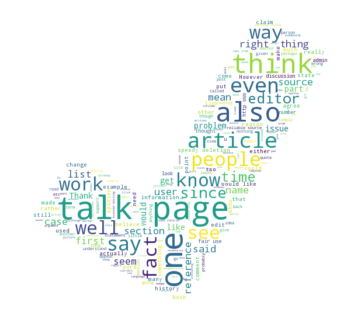

In [231]:
# wordcloud plot for clean comments
wordcloud_clean = wordcloud_generator('clean','white','image/mask_clean.jpg')
wordcloud_clean_plot = plt.imshow(wordcloud_clean.recolor(colormap = 'viridis', random_state = 29), interpolation = 'bilinear')
plt.axis("off")
plt.show()

#save the figure
fig_wordcloud_clean = wordcloud_clean_plot.get_figure()
fig_wordcloud_clean.savefig('figure/wordcloud_toxic.eps')

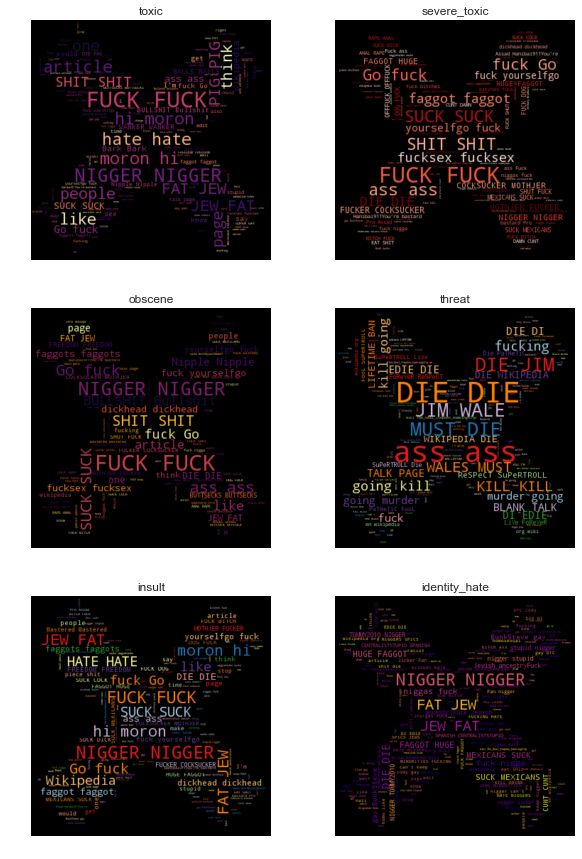

In [218]:
# wordcloud plot for subtypes of toxic comments
toxic_types = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
colormaps = ['magma', 'Reds', 'inferno', 'Paired_r', 'Paired_r', 'plasma']

plt.subplots(3,2, figsize=(10,15))
i = 1
for toxic_type, colormap in zip(toxic_types, colormaps):
    plt.subplot(3,2,i)
    wordcloud_toxic = wordcloud_generator(toxic_type,'black','image/mask_toxic.jpg')
    wordcloud_toxic_plot = plt.imshow(wordcloud_toxic.recolor(colormap = colormap, random_state = 29), interpolation = 'bilinear')
    plt.axis("off")
    plt.gca().set_title(toxic_type)
    i += 1
plt.show()

# save the figure
fig_wordcloud_toxic = wordcloud_toxic_plot.get_figure()
fig_wordcloud_toxic.savefig('figure/wordcloud_toxic.eps')

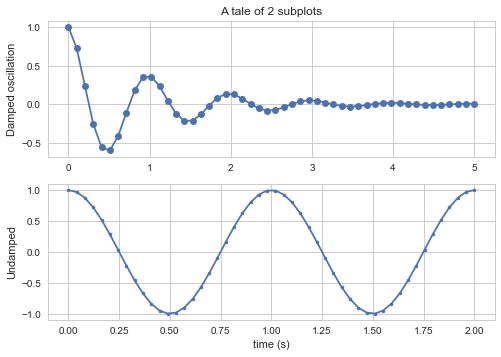

In [176]:
x1 = np.linspace(0.0, 5.0)
x2 = np.linspace(0.0, 2.0)

y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)

plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('A tale of 2 subplots')
plt.ylabel('Damped oscillation')

plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('time (s)')
plt.ylabel('Undamped')

plt.show()

---
<a id='step1'></a>
## Step 1: Clean Text Data

First, let’s load one document and look at the raw tokens split by white space. We will use the `load_doc()` function developed in the previous section. We can use the split() function to split the loaded document into tokens separated by white space.
In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

---
<a id='step2'></a>
## Step 2: Develop Vocabulary

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [ ]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [ ]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [ ]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [ ]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [ ]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

The CNN are commonly made up of only three layer types: CONV, POOL(usually Max Pool) and FC(fully connected). The RELU activation function is usually applied to the CONV layer as elementwise non-linearity. 

Here, I have followed the most common form of a ConvNet architecture, which stacks a few CONV-RELU layers, follows them with POOL layers and Dropout layers, and repeats this pattern until the image has been merged spatially to a small size (28 by 28). The CONV-RELU layers apply a increasing number of small (3 by 3) filers, which contain non-linearities that make their features more expressive. The MaxPooling layers reduce the spatial size to the 1/4 of the previous layer every time applied. The Dropout layers help to prevent overfitting. 

At some point (here 28 by 28, not small enough), it is common to transition to fully-connected layers (Dense 512). The last fully connected layer connects to the output(Dense 133) corresponding to the 133 kinds of dogs.

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.initializers import VarianceScaling

model = Sequential()

initial = VarianceScaling(scale=2.0, mode='fan_in',distribution='normal',seed=100)

model.add(Conv2D(filters=16, kernel_size=3,kernel_initializer = initial, bias_initializer = 'zeros',
                 padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=3, kernel_initializer = initial, bias_initializer = 'zeros',
                 padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=2, kernel_initializer = initial, bias_initializer = 'zeros',
                 padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,kernel_initializer = initial, bias_initializer = 'zeros', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(133, activation = 'softmax'))

model.summary()

### Compile the Model

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [ ]:
from keras.callbacks import ModelCheckpoint  

### specify the number of epochs that you would like to use to train the model.
epochs = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [ ]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [ ]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [ ]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture
The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

### Compile the Model

In [ ]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [ ]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [ ]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [ ]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

### Predict Dog Breed with the Model

In [ ]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [ ]:
### Obtain bottleneck features from another pre-trained CNN.
def load_bottleneck_features(filename):
    #load the bottleneck features
    bottleneck_features = np.load(filename)
    return bottleneck_features

#VGG19_bnf = load_bottleneck_features('bottleneck_features/DogVGG19Data.npz')
#ResNet50_bnf = load_bottleneck_features('bottleneck_features/DogResnet50Data.npz')
#Inception_bnf = load_bottleneck_features('bottleneck_features/DogInceptionV3Data.npz')
Xception_bnf = load_bottleneck_features('bottleneck_features/DogXceptionData.npz')

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

|bottleneck features|following layers|total parameters|accuracy|
|:----------:|:-------:|:----:|:----:|
|VGG-19|Dense(512), Dense(133)|330,885|73.3254%|
|ResNet50|Dense(512), Dense(133)|1,117,317|76.6746%|
|Inception|Dense(512), Dense(133)|1,117,317|78.3493%|
|Xception|Dense(512), Dense(133)|1,117,317|81.8182%|

As shown in the above table, I have tested four pre-trained models with similar architectures and Xception shows the best accuracy of 81%. 

As for the architecture, I added a GlobalAveragePooling layer first to minimize overfitting and to detect if a single feature exists. The output is 2048 then, if add a output layer directly, it reduces the nodes drastically and may lose some important information. So I add a Dense layer of 512 nodes with RELU activation, and then the output layer with 133 nodes correspoding to the total kinds of dogs. 

In [ ]:
### Define your architecture.
def create_model(bottleneck_features):
    model = Sequential()
    model.add(GlobalAveragePooling2D(input_shape = bottleneck_features['train'].shape[1:]))
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(133, activation = 'softmax'))
    model.summary()
    return model

#VGG19_model = create_model(VGG19_bnf)
#ResNet50_model = create_model(ResNet50_bnf)
#Inception_model = create_model(Inception_bnf)
Xception_model = create_model(Xception_bnf)

### (IMPLEMENTATION) Compile the Model

In [ ]:
### Compile the model.
def compile_model(model):
    model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
    return

#compile_model(VGG19_model)
#compile_model(ResNet50_model)
#compile_model(Inception_model)
compile_model(Xception_model)

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [ ]:
from keras.callbacks import ModelCheckpoint  
### Train the model.
def train_model(model, bottleneck_features, model_checkpoint_path, epochs = 20, batch_size = 20):
    checkpointer = ModelCheckpoint(filepath = model_checkpoint_path, 
                                   verbose = 1, save_best_only = True)
    
    model.fit(bottleneck_features['train'], train_targets,
              validation_data = (bottleneck_features['valid'], valid_targets),
              epochs = epochs, batch_size = batch_size, callbacks = [checkpointer], verbose = 1) 

#train_model(VGG19_model, VGG19_bnf, 'saved_models/weights.best.VGG19.hdf5')
#train_model(ResNet50_model, ResNet50_bnf, 'saved_models/weights.best.ResNet50.hdf5')
#train_model(Inception_model, Inception_bnf, 'saved_models/weights.best.Inception.hdf5')
train_model(Xception_model, Xception_bnf, 'saved_models/weights.best.Xception.hdf5')

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [ ]:
### Load the model weights with the best validation loss.
def load_weights(model, model_checkpoint_path):
    model.load_weights(model_checkpoint_path)
    return

#load_weights(VGG19_model, 'saved_models/weights.best.VGG19.hdf5')
#load_weights(ResNet50_model, 'saved_models/weights.best.ResNet50.hdf5')
#load_weights(Inception_model, 'saved_models/weights.best.Inception.hdf5')
load_weights(Xception_model, 'saved_models/weights.best.Xception.hdf5')


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [ ]:
### Calculate classification accuracy on the test dataset.
def model_accuracy(model, bottleneck_features):
    #get index of predicted dog breed for each image in test set
    model_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in bottleneck_features['test']]
    # report test accuracy
    test_accuracy = 100*np.sum(np.array(model_predictions)==np.argmax(test_targets, axis=1))/len(model_predictions)
    print('Test accuracy: %.4f%%' % test_accuracy)
    
#model_accuracy(VGG19_model, VGG19_bnf)
#model_accuracy(ResNet50_model, ResNet50_bnf)
#model_accuracy(Inception_model, Inception_bnf)
model_accuracy(Xception_model, Xception_bnf)

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [ ]:
### Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the Xception model.
from extract_bottleneck_features import extract_Xception
def Xception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Xception_model.predict(bottleneck_feature)
    # return dog breed that is predicted by Xception model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [ ]:
# Algorithm that detects if dog, human or neither in a given image 
def dog_app(img_path):
    # load color (BGR) image
    img = cv2.imread(img_path)
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # display the image along withbounding
    plt.imshow(cv_rgb)
    plt.xticks([]), plt.yticks([])
    plt.show()
    
    is_dog = dog_detector(img_path)
    is_human = face_detector(img_path)
    
    if (not is_dog) and (not is_human):
        print("Emm...I don't see a human or dog in this image. Give me another image please.")
        
    else:
        # predict breed
        predicted_breed = Xception_predict_breed(img_path)
        if is_dog:
            print("It is a DOG! The breed is {}.".format(predicted_breed.replace("_"," ")))
        else:
            print("Hey, you look like a {}.".format(predicted_breed.replace("_"," "))) 
        
    return

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

The output is better than I expected. It correctly identified dogs and human and showed that I am a potential "Dachshund" person :)

However, it still needs improvement as it misidentified the my neighbour's dog Bandit as "Chesapeake bay retriever" while he is "Labrador retriever", partially because the image is blurred. 

The possible improvements would be:
 - Add dropout layers to reduce overfitting
 - Gridsearch for fine hyperparameter tuning
 - Augmentation

In [ ]:
dog_app('dogImages/test/004.Akita/Akita_00258.jpg')

In [ ]:
dog_app('testImages/Bandit.jpg')

In [ ]:
dog_app('testImages/DL.jpg')

In [ ]:
dog_app('testImages/lighthouse.jpg')

In [ ]:
dog_app('testImages/sea.jpg')